In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.40', '1.0.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-marathi/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-marathi/classification')

In [6]:
!ls

Marathi_Classification_Data_News_Headlines.csv
Marathi_Classification_Model.ipynb


In [7]:
df = pd.read_csv(path/'Marathi_Classification_Data_News_Headlines.csv')
df.tail()

,headline,label
12087,धक्कादायक! एक्स्प्रेसमध्ये महिला कोचच्या पायऱ्...,state
12088,चर्चा करून तोडगा काढण्यास अण्णा सकारात्मक -गिर...,state
12089,जिल्हा बँकांमधील जुन्या नोटा अखेर RBI स्विकारण...,state
12090,"ज्यांनी आपल्याला मोठं केलं त्यांना विसरू नका, ...",state
12091,दाभोलकर कुटुंबीयांनी घेतली पोलीस आयुक्तींची भेट,state


In [8]:
df['label'].unique()

array(['entertainment', 'sports', 'state'], dtype=object)

In [9]:
print('Entertainment', (df['label'] == 'entertainment').sum())
print('Sports', (df['label'] == 'sports').sum())
print('State', (df['label'] == 'state').sum())

Entertainment 3323
Sports 1222
State 7547


In [10]:
df['headline'][0]

'दीपिकाचं आयुष्यात असणंच माझ्यासाठी सर्व काही - रणवीर'

In [11]:
df.shape

(12092, 2)

In [12]:
df[df['headline'].isnull()].shape

(0, 2)

In [13]:
label_cols = list(range(1,df.shape[1]))

In [14]:
print(label_cols)

[1]


In [15]:
id_to_col = list(df.columns)

In [16]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [18]:
class MarathiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/marathi_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [19]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/marathi_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [20]:
# 30,000 is the vocab size that we chose in sentencepiece
marathi_vocab = Vocab(itos)

In [21]:
tokenizer = Tokenizer(tok_func=MarathiTokenizer, lang='mr')

In [22]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [23]:
data_lm = TextDataBunch.from_csv(path=path, csv_name='Marathi_Classification_Data_News_Headlines.csv', text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=marathi_vocab)

In [24]:
data_lm.save()

In [25]:
bs=48

In [26]:
data_lm = TextLMDataBunch.load(path, 'tmp', bs=bs)

In [27]:
data_lm.show_batch()

idx,text
0,"▁x x bo s ▁सीमा ▁भागातील ▁मराठी ▁भाषिक ांना ▁महाराष्ट्र ानं ▁वा - यावर ▁सोड लं य ▁का ? ▁भाग - ▁2) ▁x x bo s ▁बालभारती च्या ▁पुस्तक ांसाठी ▁कागद ▁खरेदी त ▁गौड बंगाल ▁x x bo s ▁मुक्त ाचा ▁' रंग ▁नवा ' ▁x x bo s ▁रहाणे , ▁पंत ची ▁शतक ाकडे ▁वाटचाल , ▁सामन्या वर ▁भारताची ▁मजबूत ▁पकड ▁x x bo s ▁शाहिद ▁आ फ्र"
1,▁समाजाचा ▁मोर्चा ▁x x bo s ▁राज्य भर ात ▁गुढीपाडव्या चा ▁उत्साह ; ▁नववर्ष ाचं ▁जल्लोष ात ▁स्वागत ▁x x bo s ▁विराट - अ नुष्का चं ▁' च ोरी ▁चोरी ▁चु प के ▁चु प के ' ▁सुरूच ▁x x bo s ▁श्री देवी ▁यांच्या ▁ट्विटर वरून ▁बो नी ▁कपूर ▁यांनी ▁केलं ▁ट् वि ट ; ▁पहिल्यांदाच ▁झाले ▁व्यक्त ! ▁x x bo s ▁सोलापुरात ▁सहकार मंत्र ्यांची ▁गाडी
2,"s ▁' बह रुप िया ' ▁रण बीर ▁आणि ▁अ नुष्का ▁x x bo s ▁या ▁आहेत ▁राज्याच्या ▁प्रभू ंकडून ▁अपेक्षा ▁x x bo s ▁बिग ▁बी ंनी ▁जागव ल्या ▁' शो ले ' च्या ▁आठवणी ▁x x bo s ▁अवतर ली ▁' लाल बाग ची ▁राणी ' ▁x x bo s ▁अवधूत चे ▁सूर ▁x x bo s ▁अरे च्या ! , प ोलिस ांनी ▁आरोपी ला ▁घातली ▁पिशवी"
3,"की ▁व र्दी ला ▁ठोकला ▁राम राम ▁x x bo s ▁मुख्यमंत्र्या ंनी ▁थांब वला ▁आठवले ंचा ▁कोपर् डी ▁दा ैर ा , ▁विमानतळ ावरुन ▁आठवले ▁माघार ी ▁x x bo s ▁फिल्म ▁रि व्ह ्यु ▁: ▁' हंस ी ▁तो ▁फ ं सी ' ▁x x bo s ▁साखर ▁कामगारांना ▁पाच वं ▁वेतन ▁देणार ▁- मुख्य मंत्री ▁x x bo s ▁मुलगा ▁पसंत ▁आहे , ▁आ लिया च्या ▁आई"
4,"bo s ▁बॅक फुट वर ▁दादा , ▁सचिन साठी ▁द्या वं ▁लागलं ▁स्पष्टीकरण ▁x x bo s ▁' गो ष्ट ▁चिर े बंदी ▁वाड्या ची ' ▁x x bo s ▁' उ च ल्या ' ▁कादंबरी ▁ते ▁सिनेमा ▁x x bo s ▁चपाती ▁वीस ▁सेंटीमीटर च ▁असावी , ▁पती च्या ▁ज ाचा मुळे ▁पत्नी ने ▁मागितला ▁घटस्फोट ▁x x bo s ▁चुकीच ं ▁वाग णाऱ्या ंना ▁स्वातंत्र्य ▁नाही , ▁तनु"


In [28]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [29]:
# Loading the pretrained language model on kannada wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-marathi/language-model/MarathiDataset/models/fourth_mr_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (9673 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/PycharmProjects/nlp-for-marathi/classification
x: LMTextList (9673 items)
[Text ▁x x bo s ▁गडचिरोली त ▁माओ वाद्य ांच्या ▁भू सुर ुंग ▁स्फोट ात ▁12 ▁जवान ▁जखमी, Text ▁x x bo s <unk> ▁l ive ▁cricket ▁score , <unk> ▁v s <unk> , ▁1 st <unk> <unk> : ▁रो ' हि ट ' ची ▁खेळी ▁व ्यर्थ , ▁ऑस्ट्रेलियाचा ▁३४ ▁धाव ांनी ▁विजय, Text ▁x x bo s ▁भुजबळ ांचा ▁पाय ▁आणखी ▁खोल ात , ▁मुंबई - नाशिक मध्ये ▁घर - कार्य ालय ांवर ▁छाप े, Text ▁x x bo s ▁' ठ ग् स ▁आॅफ ▁हिंद ो स्तान ' वर च्या ▁टीके ला ▁आमिर नं ▁दिलं ▁' अ सं ' ▁उत्तर, Text ▁x x bo s ▁दिग्दर्शक ▁संदीप ▁सावंत शी ▁दिल खु ला स ▁गप्पा]...
Path: /home/gaurav/PycharmProjects/nlp-for-marathi/classification;

Valid: LabelList
y: LMLabel (2419 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/PycharmProjects/nlp-for-marathi/classification
x: LMTextList (2419 item

In [30]:
# Fine tuning the prtrained LM on current dataset

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


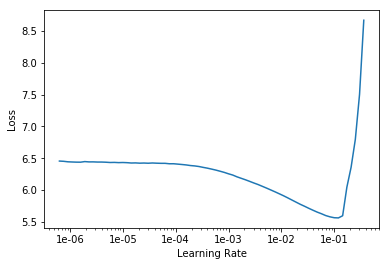

In [32]:
learn.recorder.plot()

In [33]:
learn.freeze()

In [34]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,5.379014,4.866922,0.328144


In [35]:
learn.save('fit_head', with_opt=True)

In [36]:
learn.load('fit_head', with_opt=True);

In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.630424,4.662682,0.340917
2,4.472055,4.422144,0.361622
3,4.248912,4.255036,0.378132
4,4.008489,4.152535,0.391455
5,3.788465,4.106253,0.398555
6,3.576840,4.085821,0.402927
7,3.405467,4.083016,0.406242
8,3.273271,4.088724,0.407015
9,3.180604,4.096419,0.407426
10,3.133704,4.097309,0.407174


In [39]:
learn.save('fine_tuned', with_opt=True)

In [40]:
learn.load('fine_tuned', with_opt=True);

In [42]:
learn.predict('सीमा भागातील मराठी',n_words=10)

'सीमा भागातील मराठी तून ▁पुन्हा ▁येते ip ▁लोकमत ▁संपवण्या ex नामे ▁x ▁द'

In [43]:
learn.save_encoder('fine_tuned_enc')

In [44]:
data_clas = TextClasDataBunch.from_csv(path=path, csv_name='Marathi_Classification_Data_News_Headlines.csv', tokenizer=tokenizer, vocab=marathi_vocab, text_cols=[0], label_cols=label_cols)

In [45]:
data_clas.show_batch()

text,target
"▁x x bo s ▁l ive ▁cricket co re , ▁v s ▁2 nd ▁test , ▁4 th ▁ day - ▁ल ंच नंतर ▁ऑस्ट्रेलिया ला ▁दोन ▁धक्के , ▁शमी ने च ▁घेतल्या ▁दोन्ही ▁विकेट , ▁पेन - ▁फिंच ▁बाद",sports
"▁x x bo s ▁b hi wan di , ve l , ▁ma le ga on ect ion ▁re s ul ts ▁2017 ▁l ive ▁: ▁पनवेल मध्ये ▁भाजप ▁तर ▁भिवंडी - माल ेगाव मध्ये ▁काँग्रेस ▁!",state
▁x x bo s ▁l o k ▁ sa b ha ▁e l e c t i o n s ▁20 19 ▁d at e : ▁बुल डा णा ▁मतदारसंघ ामध्ये ▁कधी ▁होणार ▁मतदान ?,state
"▁x x bo s ▁l ive ▁cricket co re , ▁v s ▁3 rd ▁test , ▁3 rd ▁ day - ▁दुसऱ्या ▁डावात ▁टीम ▁इंडिया ▁को स ळ ली , ▁पाच ▁गडी ▁बाद",sports
▁x x bo s ▁v id e o ▁v i r al ▁: ▁मैदानात ▁घुस लेल्या ▁ फॅन ची ▁धो नी ने ▁घेतली ▁अशी ▁फिरकी ; ▁विराट ही ▁राहिला ▁बघत !,sports


In [46]:
data_clas.sanity_check()

In [47]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)

In [48]:
learn.load_encoder('fine_tuned_enc')

In [49]:
learn.freeze()

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


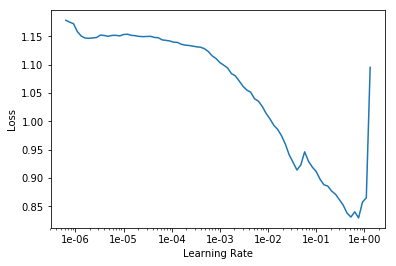

In [51]:
learn.recorder.plot()

In [52]:
learn.loss_func.func

CrossEntropyLoss()

In [53]:
kappa = KappaScore()

In [54]:
learn.metrics = [kappa, accuracy]

In [55]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.430313,0.325980,0.759054,0.876809


In [56]:
learn.save('first-full')

In [57]:
learn.load('first-full');

In [58]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.390041,0.285356,0.800648,0.901199
2,0.355504,0.255062,0.813784,0.904919
3,0.282071,0.243756,0.830394,0.913601
4,0.233013,0.244071,0.834999,0.917321
5,0.191804,0.249673,0.843211,0.919802


In [59]:
learn.save('final')

In [60]:
learn.predict('धक्कादायक! एक्स्प्रेसमध्ये महिला कोचच्या')

(Category state, tensor(2), tensor([0.0020, 0.0171, 0.9808]))

In [61]:
learn.predict("नरेंद्र मोदी गोव्याला रवाना, पर्रिकर यांच्या पार्थिवाचे अंत्यदर्शन घेणार")

(Category state, tensor(2), tensor([0.0122, 0.0039, 0.9839]))

In [62]:
learn.predict("सलमान आणणार स्वत:चं चॅनेल?")

(Category entertainment,
 tensor(0),
 tensor([9.9969e-01, 2.5938e-04, 5.0702e-05]))

In [63]:
learn.predict("धमा’केदार’! टीम इंडियासाठी केली ‘ही’ सर्वोत्तम कामगिरी")

(Category sports, tensor(1), tensor([4.1675e-03, 9.9582e-01, 1.3189e-05]))